In [25]:
# Standard library imports
import os
from typing import TypedDict, Literal

# Third-party imports
from dotenv import load_dotenv
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI


In [26]:
# Load environment variables from .env file
load_dotenv()


False

In [28]:
# Initialize the Gemini model
gemini_model = ChatGoogleGenerativeAI(model="gemini-2.5-flash")


E0000 00:00:1763972700.236230  639549 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


# **Notes on `Literal` in Python (Typing Module)**

**Purpose:** To define variables or function parameters that are allowed to take *only specific, fixed values*.

---

## **1. What is a Literal?**

In general programming, a **literal** is a value written exactly as it is:

* `5` (integer literal)
* `"hello"` (string literal)
* `True` (boolean literal)

---

## **2. What is `Literal` in Python Typing?**

`Literal` is a type hint from the `typing` module used to restrict a value to **exact predefined constants**, not just a broad type.

### **Example**

```python
from typing import Literal

def foo(x: Literal[5]):
    ...
```

Meaning:

* `x` **must be exactly** 5
* `x = 6` → type-check error
* `x = "5"` → type-check error
* `x = 5` → allowed

---

## **3. Why `Literal` Exists?**

Python is dynamically typed, but type checkers (like **mypy**, Pyright) need a way to enforce stricter constraints.

`Literal` helps by:

* preventing invalid configuration values
* enabling better auto-completion
* reducing runtime bugs
* documenting acceptable values clearly

---

## **4. How `Literal` Works**

### **Single-value restriction**

```python
x: Literal[10]
```

Only `10` is allowed.

### **Multiple allowed values**

```python
mode: Literal["formal", "casual"]
```

Allowed:

* `"formal"`
* `"casual"`

Anything else → type error.

### **Boolean Literals**

```python
flag: Literal[True]
```

Only `True` allowed.

---

## **5. Practical Use Cases**

### **(a) Mode/Config Settings**

```python
def render(theme: Literal["light", "dark"]):
    ...
```

### **(b) Constants in APIs**

Used heavily in frameworks like **FastAPI**, **Pydantic**, **attrs**.

### **(c) Type-safe flags**

```python
def retry(strategy: Literal["fast", "safe", "aggressive"]):
    ...
```

### **(d) Replacing simple Enums**

When you need enum-like behaviour but without defining a full Enum class.

---

## **6. Differences: `Literal` vs `Enum`**

| Feature             | `Literal`                     | `Enum`                       |
| ------------------- | ----------------------------- | ---------------------------- |
| Purpose             | Restrict to fixed values      | Create named constant groups |
| Runtime enforcement | No                            | Yes                          |
| Overhead            | Zero                          | Slight                       |
| Best for            | Simple, small sets of options | Large/complex states         |

---

## **7. Summary**

* `Literal` restricts variables to **specific fixed values**.
* Helps type checkers catch mistakes before runtime.
* Ideal for config modes, flags, and small option sets.
* Example:

  ```python
  def greet(style: Literal["formal", "casual"]): ...
  ```
* Makes code safer, clearer, and more maintainable.

---


In [29]:
class SentimentSchema(BaseModel):
    """
    Schema for sentiment analysis output.
    
    Attributes:
        sentiment: Binary sentiment classification (positive or negative)
    """
    sentiment: Literal["positive", "negative"] = Field(
        description="Sentiment of the review (positive or negative)"
    )


In [30]:
class DiagnosisSchema(BaseModel):
    """
    Schema for diagnosing negative review details.
    
    Attributes:
        issue_type: Category of the issue mentioned in the review
        tone: Emotional tone expressed by the user
        urgency: Priority level of the issue
    """
    issue_type: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(
        description="The category of issue mentioned in the review"
    )
    tone: Literal["angry", "frustrated", "disappointed", "calm"] = Field(
        description="The emotional tone expressed by the user"
    )
    urgency: Literal["low", "medium", "high"] = Field(
        description="How urgent or critical the issue appears to be"
    )


In [31]:
# Create structured output models
structured_sentiment_model = gemini_model.with_structured_output(SentimentSchema)
structured_diagnosis_model = gemini_model.with_structured_output(DiagnosisSchema)


In [32]:
# Test sentiment analysis
test_prompt = "What is the sentiment of the following review - The software too good"
test_sentiment = structured_sentiment_model.invoke(test_prompt).sentiment
print(f"Test sentiment: {test_sentiment}")


Test sentiment: positive


In [ ]:
class ReviewState(TypedDict):
    
    """
        State schema for the review analysis workflow.
        
        Attributes:
            review: The original review text
            sentiment: Detected sentiment (positive or negative)
            diagnosis: Detailed diagnosis for negative reviews
            response: Generated response message
    """
    review: str
    sentiment: Literal["positive", "negative"]
    diagnosis: dict
    response: str


In [33]:
# Node functions for the review analysis workflow


def find_sentiment(state: ReviewState) -> dict:
    """
    Analyze the sentiment of a review.
    
    Args:
        state: Current workflow state containing the review text
        
    Returns:
        Dictionary with sentiment classification
    """
    prompt = (
        f"Analyze the sentiment of the following review:\n\n"
        f"{state['review']}\n\n"
        f"Classify as either 'positive' or 'negative'."
    )
    
    sentiment = structured_sentiment_model.invoke(prompt).sentiment
    
    return {"sentiment": sentiment}


def check_sentiment(state: ReviewState) -> Literal["positive_response", "run_diagnosis"]:
    """
    Route to appropriate handler based on sentiment.
    
    Args:
        state: Current workflow state with sentiment information
        
    Returns:
        Name of the next node to execute
    """
    if state["sentiment"] == "positive":
        return "positive_response"
    else:
        return "run_diagnosis"


def positive_response(state: ReviewState) -> dict:
    """
    Generate a thank-you response for positive reviews.
    
    Args:
        state: Current workflow state containing the review
        
    Returns:
        Dictionary with generated response message
    """
    prompt = (
        f"Write a warm, professional thank-you message in response to this positive review:\n\n"
        f'"{state["review"]}"\n\n'
        f"Also, kindly invite the user to leave feedback on our website. "
        f"Keep the tone friendly and appreciative."
    )
    
    response = gemini_model.invoke(prompt).content
    
    return {"response": response}


def run_diagnosis(state: ReviewState) -> dict:
    """
    Diagnose the details of a negative review.
    
    Args:
        state: Current workflow state containing the review
        
    Returns:
        Dictionary with diagnosis details (issue_type, tone, urgency)
    """
    prompt = (
        f"Analyze this negative review and provide a detailed diagnosis:\n\n"
        f'"{state["review"]}"\n\n'
        f"Identify:\n"
        f"1. Issue type (UX, Performance, Bug, Support, or Other)\n"
        f"2. User's emotional tone (angry, frustrated, disappointed, or calm)\n"
        f"3. Urgency level (low, medium, or high)"
    )
    
    diagnosis = structured_diagnosis_model.invoke(prompt)
    
    return {"diagnosis": diagnosis.model_dump()}


def negative_response(state: ReviewState) -> dict:
    """
    Generate an empathetic resolution message for negative reviews.
    
    Args:
        state: Current workflow state with review and diagnosis
        
    Returns:
        Dictionary with generated response message
    """
    diagnosis = state["diagnosis"]
    
    prompt = (
        f"You are a professional customer support assistant.\n\n"
        f"Context:\n"
        f"- Issue type: {diagnosis['issue_type']}\n"
        f"- User's tone: {diagnosis['tone']}\n"
        f"- Urgency: {diagnosis['urgency']}\n\n"
        f"Write an empathetic, helpful, and professional response that:\n"
        f"1. Acknowledges the user's concern\n"
        f"2. Apologizes for the inconvenience\n"
        f"3. Offers concrete next steps or solutions\n"
        f"4. Shows commitment to resolving the issue"
    )
    
    response = gemini_model.invoke(prompt).content
    
    return {"response": response}


In [34]:
# Build the review analysis workflow graph

# Initialize the state graph
graph = StateGraph(ReviewState)

# Add nodes to the graph
graph.add_node("find_sentiment", find_sentiment)
graph.add_node("positive_response", positive_response)
graph.add_node("run_diagnosis", run_diagnosis)
graph.add_node("negative_response", negative_response)

# Define the workflow edges
# Start with sentiment analysis
graph.add_edge(START, "find_sentiment")

# Add conditional routing based on sentiment
graph.add_conditional_edges(
    "find_sentiment",
    check_sentiment,
    {
        "positive_response": "positive_response",
        "run_diagnosis": "run_diagnosis"
    }
)

# Positive path ends after response
graph.add_edge("positive_response", END)

# Negative path: diagnosis -> response -> end
graph.add_edge("run_diagnosis", "negative_response")
graph.add_edge("negative_response", END)

# Compile the workflow
workflow = graph.compile()


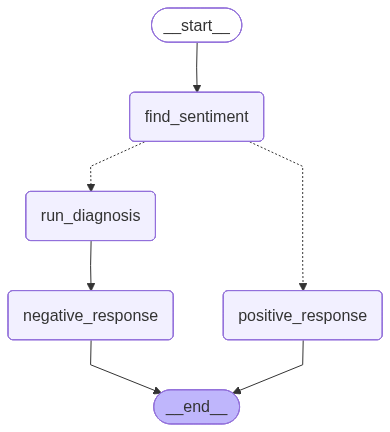

In [35]:
# Visualize the workflow
workflow


In [36]:
# Test the workflow with a negative review
initial_state = {
    "review": (
        "I've been trying to log in for over an hour now, and the app keeps "
        "freezing on the authentication screen. I even tried reinstalling it, "
        "but no luck. This kind of bug is unacceptable, especially when it "
        "affects basic functionality."
    )
}

# Run the workflow
result = workflow.invoke(initial_state)

# Display results
print("=" * 80)
print("REVIEW ANALYSIS RESULTS")
print("=" * 80)
print(f"\nOriginal Review:\n{result['review']}")
print(f"\nDetected Sentiment: {result['sentiment']}")

if result.get('diagnosis'):
    print(f"\nDiagnosis:")
    print(f"  - Issue Type: {result['diagnosis']['issue_type']}")
    print(f"  - Tone: {result['diagnosis']['tone']}")
    print(f"  - Urgency: {result['diagnosis']['urgency']}")

print(f"\nGenerated Response:\n{result['response']}")
print("=" * 80)


REVIEW ANALYSIS RESULTS

Original Review:
I've been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality.

Detected Sentiment: negative

Diagnosis:
  - Issue Type: Bug
  - Tone: frustrated
  - Urgency: high

Generated Response:
Subject: Urgent Attention: Regarding the Critical Bug You're Experiencing

Dear [User Name],

I'm truly sorry to hear you're encountering such a critical bug, and I completely understand how incredibly frustrating and disruptive this must be, especially given the high urgency of your work. Please accept our sincerest apologies for the significant inconvenience and stress this issue is undoubtedly causing you.

We take reports like this with the utmost seriousness, and our priority right now is to get this resolved for you as quickly as possible. To help us investigate and pinpoint the issue immedia